In [1]:
import os
import sys
import pandas as pd
import datetime
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
#import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta


In [5]:
import pandas_gbq

In [41]:
import numpy_financial as npf

## Ferratum AU Oct 2021

In [23]:
###Manual: adjust book_id and region
book_id='3435712288'
region='au' ###'au' or 'eu'

In [13]:
query_purchase='''SELECT book_id,actual_purchase_price*-1 as purchase_local_ccy,settlement_date
                FROM presentation.dim_books db
                where 1=1
                and book_id='{}' '''.format(book_id)

In [15]:
df_purch = pandas_gbq.read_gbq(query_purchase,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [171]:
df_purch

,book_id,purchase_local_ccy,settlement_date
0,3435712288,-659683.0,2021-10-20


In [206]:
if region=='au':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_au
            where 1=1
            and book_id='{}' '' '''.format(book_id)
elif region=='eu':
    query_cf='''select * except (market, dca_name) from
            presentation.collections_eu
            where 1=1
            and book_id='{}' '' '''.format(book_id)
else:
    query_cf=None


In [208]:
df_cf=pandas_gbq.read_gbq(query_cf,project_id="data-team-318806")

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████|


In [209]:
df_cf

,book_id,book_name,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01
0,3435712288,Ferratum / Multitude Oct 21,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2813.17,3277.00,3851.00,2848.79,2514.33,1219.49,973.61,1655.67,1200.00,1156.45
1,3435712288,Ferratum / Multitude Oct 21,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,16053.32,4703.93,7357.25,5227.49,1559.51,1789.87,634.38,896.98,-421.64,935.07
2,3435712288,Ferratum / Multitude Oct 21,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,179.00,80.00,90.00,130.00,68.00,40.00,20.00,20.00,20.00,20.00
3,3435712288,Ferratum / Multitude Oct 21,261402.0,49947.22,120861.03,155443.49,193742.23,121042.02,115673.38,92877.99,...,3814.20,3855.34,3015.16,2890.92,2541.77,3612.70,3260.36,4032.07,3602.80,4215.02


In [210]:
df_cf_agg = df_cf.groupby(['book_id', 'book_name']).sum().reset_index().copy()

In [211]:
df_cf_agg

,book_id,book_name,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,...,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01
0,3435712288,Ferratum / Multitude Oct 21,261402.0,49947.22,120861.03,155443.49,193742.23,121042.02,115673.38,92877.99,...,22859.69,11916.27,14313.41,11097.2,6683.61,6662.06,4888.35,6604.72,4401.16,6326.54


In [216]:
book_name=df_cf_agg.iloc[0,1]

In [218]:
cf_values = df_cf_agg.iloc[0, 2:].tolist()

In [220]:
relevant_months=df_cf_agg.columns[2:].tolist()

In [222]:
df_agg_cf_format=pd.DataFrame({'collection':cf_values,'month':relevant_months})

In [224]:
df_agg_cf_format['month_cohort']=range(1, len(df_agg_cf_format)+1)


In [226]:
df_agg_cf_format.head(2)

,collection,month,month_cohort
0,261402.00,2021-09-01,1
1,49947.22,2021-10-01,2


In [228]:
cashflow=[df_purch.iloc[0,1]]+df_agg_cf_format['collection'].tolist()

In [232]:
cashflow=[round(value, 2) for value in cashflow]

In [268]:
####Calculating dynamic IRR
irr=[]
selected_values=[cashflow[0]]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    irr_temp = round(npf.irr(selected_values),4)
    irr.append(irr_temp)
    
df_agg_cf_format['irr']=irr

In [278]:
#### Calculating Dynamic MOIC

In [320]:
moic_num=0.0
moic_temp=0.0
moic=[]
purchase_value=abs(df_purch.iloc[0,1])
selected_values=[]
for i in range(1, len(cashflow)):
    selected_values.append(cashflow[i])
    moic_num = round((sum(selected_values)),2)
    moic_temp=round(moic_num/purchase_value,2)
    moic.append(moic_temp)
    
df_agg_cf_format['moic']=moic 

In [340]:
df_agg_cf_format['book_id']=book_id
df_agg_cf_format['book_name']=book_name
df_agg_cf_format['purchase_local_ccy']=abs(df_purch.iloc[0,1])
df_agg_cf_format['region']=region.upper()

In [344]:
df_agg_cf_format.head()

,collection,month,month_cohort,irr,moic,book_id,book_name,purchase_local_ccy,region
0,261402.00,2021-09-01,1,-0.6037,0.40,3435712288,Ferratum / Multitude Oct 21,659683.0,AU
1,49947.22,2021-10-01,2,-0.4628,0.47,3435712288,Ferratum / Multitude Oct 21,659683.0,AU
2,120861.03,2021-11-01,3,-0.2123,0.66,3435712288,Ferratum / Multitude Oct 21,659683.0,AU
3,155443.49,2021-12-01,4,-0.0484,0.89,3435712288,Ferratum / Multitude Oct 21,659683.0,AU
4,193742.23,2022-01-01,5,0.0604,1.18,3435712288,Ferratum / Multitude Oct 21,659683.0,AU


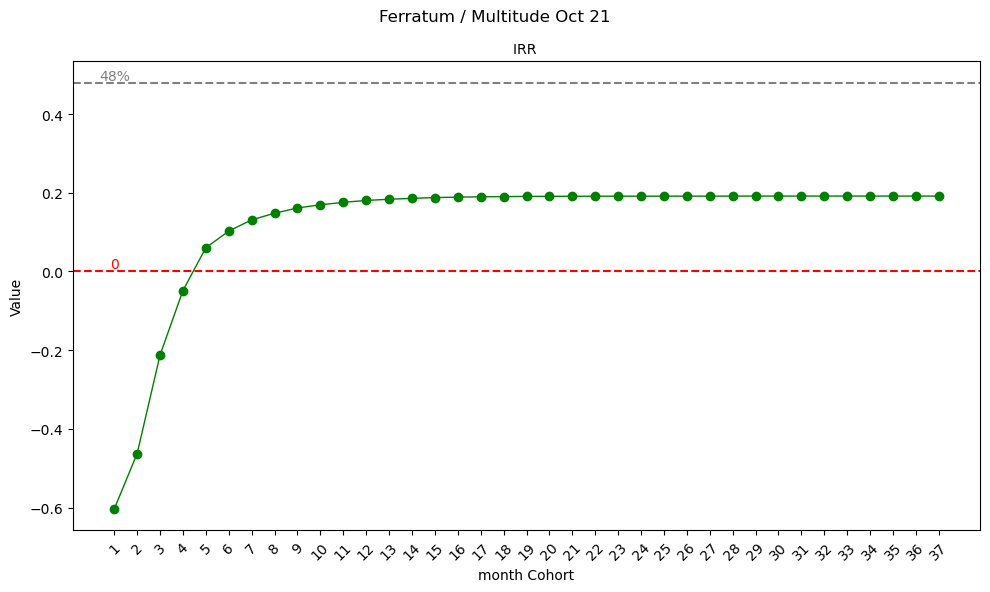

In [382]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green')

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['irr'], color='green', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('Value')
plt.suptitle(book_name, fontsize=12)
plt.title('IRR ', fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['irr']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['irr'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 0.48
plt.axhline(y=0.48, color='gray', linestyle='--', label='y = 0.48')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0.48, '48%', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

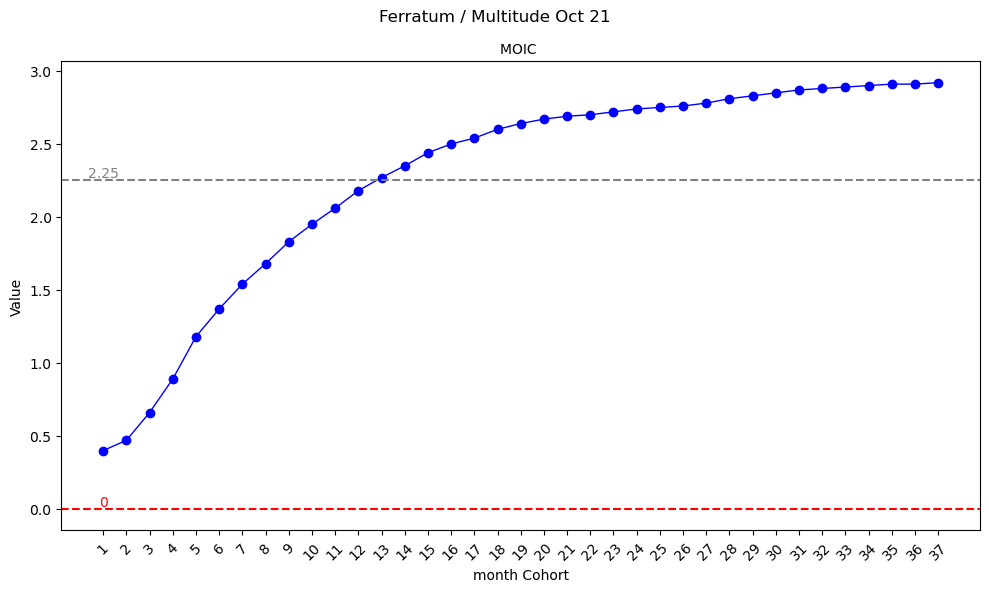

In [380]:
plt.figure(figsize=(10, 6))  # Make the figure wider
plt.scatter(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue')

# Add a line connecting the dots
plt.plot(df_agg_cf_format['month_cohort'], df_agg_cf_format['moic'], color='blue', linestyle='-', linewidth=1)

# Add labels and title
plt.xlabel('month Cohort')
plt.ylabel('Value')
plt.suptitle(book_name, fontsize=12)
plt.title('MOIC ', fontsize=10)

# Rotate x-axis labels for better readability (optional)

#x_labels = df_agg_cf_format['month_cohort'].dt.strftime('%Y-%m-%d')  # Format as string
#short_x_labels = x_labels.str.slice(0, 7)  # Get the first 6 letters

plt.xticks(df_agg_cf_format['month_cohort'], rotation=45)


# Annotate each point with its y-value 
#for i, value in enumerate(df_agg_cf_format['irr']):
#    plt.text(df_agg_cf_format['month_cohort'][i], df_agg_cf_format['irr'][i], 
#             f'{value:,.2f}', ha='center', va='bottom', fontsize=9)


#plt.axhline(y=df_average, color='red', linestyle='--', label=f'Average: {df_average:,.2f}')

#plt.text(df_agg_cf_format['month_cohort'].min(), df_average, f'Avg: {df_average:,.2f}', 
 #        color='red', va='bottom', ha='right', fontsize=10)

# Add a line where y = 0
plt.axhline(y=0, color='red', linestyle='--', label='y = 0')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 0, '0', color='red', va='bottom', ha='center', fontsize=10)


# Add a line where y = 2.25
plt.axhline(y=2.25, color='gray', linestyle='--', label='y = 2.25')
# Add a label for the y = 0 line
plt.text(df_agg_cf_format['month_cohort'].min(), 2.25, '2.25', color='gray', va='bottom', ha='center', fontsize=10)

# Show plot
plt.tight_layout()  
plt.show()

In [ ]:
#########################################

In [242]:
df_agg_cf_format.to_csv('verification.csv', index=False)

In [238]:
npf.irr(cashflow) * 100

19.174297894368507

In [240]:
df_agg_cf_format

,collection,month,month_cohort
0,261402.00,2021-09-01,1
1,49947.22,2021-10-01,2
2,120861.03,2021-11-01,3
3,155443.49,2021-12-01,4
4,193742.23,2022-01-01,5
5,121042.02,2022-02-01,6
6,115673.38,2022-03-01,7
7,92877.99,2022-04-01,8
8,98480.75,2022-05-01,9
9,75647.75,2022-06-01,10


In [248]:
my_list = [-10, 3, 2, 5, 6, 80, 711, 83, 999, 1001]

# Initialize an empty list to hold the selected sublists
selected_values = []

# Loop through the list starting from 2 up to the length of the list
for i in range(2, len(my_list) + 1):
    # Append the first i values to the selected_values list
    selected_values.append(my_list[:i])

print(selected_values)

[[-10, 3], [-10, 3, 2], [-10, 3, 2, 5], [-10, 3, 2, 5, 6], [-10, 3, 2, 5, 6, 80], [-10, 3, 2, 5, 6, 80, 711], [-10, 3, 2, 5, 6, 80, 711, 83], [-10, 3, 2, 5, 6, 80, 711, 83, 999], [-10, 3, 2, 5, 6, 80, 711, 83, 999, 1001]]
